Downloads GloVe word vectors (42B tokens, 300D vectors) for initializing the embedding layer with meaningful word semantics.

In [1]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove.42B.300d.zip
!rm glove.42B.300d.zip

--2025-04-09 10:14:16--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2025-04-09 10:14:16--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2025-04-09 10:14:17--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1,7G) [application/zip]


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3 as inception
from tensorflow.keras.models import Model
from tensorflow.keras import Input
import tensorflow.keras.preprocessing.image as tf_image
import pandas as pd
import numpy as np

2025-04-09 10:46:47.576531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 10:46:47.576950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 10:46:47.579381: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 10:46:47.586440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744184807.598133  594516 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744184807.60

In [3]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
#Uses InceptionV3 pre-trained on ImageNet to extract 2048-dimensional 
#features from the image (before the final softmax layer).

WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
START = "startseq"
STOP = "endseq"
EPOCHS = 10
preprocess_input = inception.preprocess_input

E0000 00:00:1744184809.327862  594516 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1744184809.336968  594516 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Preprocesses the image and outputs its feature vector.

In [4]:
def encodeImage(img):
    img = img.resize((WIDTH, HEIGHT))
    x = tf_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = encode_model.predict(x) # Get the encoding vector for the image
    x = np.reshape(x, OUTPUT_DIM )

    return x

In [5]:
img=tf_image.load_img('/home/db21160/Desktop/images/1.jpg', target_size=(299,299))
encodeImage(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([0.36294496, 0.21345311, 0.802015  , ..., 0.36653116, 0.22385031,
       0.50166786], dtype=float32)

Reads a CSV that maps image filenames to captions and appends startseq and endseq tokens to each caption.

In [6]:
data=pd.read_csv('/home/db21160/Desktop/image_caption_map.csv')

In [7]:
data.head(2)

,caption,url,file_name
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,1.jpg
1,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...,3.jpg


In [8]:
data['caption']=data['caption'].apply(lambda x:START+' '+x+' '+STOP)

In [9]:
data.shape[0]

1832

Encodes all images and stores their 2048D vectors in a dictionary using filename ID as key. Skips any problematic files.

In [10]:
remove_these=[]
encoded_images={}
for i in range(data.shape[0]):
    image_path='/home/db21160/Desktop/images/'+data['file_name'][i]
    print(image_path)
    try:
        img = tf_image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoded_images[int(data['file_name'][i].split('.')[0])] = encodeImage(img)
    except:
        print('remove: ',i)
        remove_these.append(data['file_name'][i])


/home/db21160/Desktop/images/1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
/home/db21160/Desktop/images/3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
/home/db21160/Desktop/images/8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
/home/db21160/Desktop/images/9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
/home/db21160/Desktop/images/12.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
/home/db21160/Desktop/images/13.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
/home/db21160/Desktop/images/14.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/15.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/16.jpg
1/1 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/84.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
/home/db21160/Desktop/images/85.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/86.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/87.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/89.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/90.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/91.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/93.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/94.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
/home/db21160/Desktop/images/95.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/97.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/99.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
/home/db21160/Desktop/images/170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
/home/db21160/Desktop/images/177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
/home/db21160/Desktop/images/181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
/home/db21160/Desktop/images/185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
/home/db21160/Desktop/images/263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
/home/db21160/Desktop/images/265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
/home/db21160/Desktop/images/266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/270.jpg
remove:  239
/home/db21160/Desktop/images/271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db2116

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
/home/db21160/Desktop/images/349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
/home/db21160/Desktop/images/352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
/home/db21160/Desktop/images/354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
/home/db21160/Desktop/images/355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
/home/db21160/Desktop/images/359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
/home/db21160/Desktop/images/360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
/home/db21160/Desktop/images/435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
/home/db21160/Desktop/images/437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
/home/db21160/Desktop/images/445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
/home/db21160/Desktop/images/447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
/home/db21160/Desktop/images/529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/530.jpg
remove:  463
/home/db21160/Desktop/images/533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
/home/db21160/Desktop/images/538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
/home/db21160/Desktop/images/539.jpg
remove:  468
/home/db21160/Desktop/images/541.jp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/619.jpg
remove:  541
/home/db21160/Desktop/images/620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
/home/db21160/Desktop/images/628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
/home/db211

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
/home/db21160/Desktop/images/706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
/home/db21160/Desktop/images/714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
/home/db21160/Desktop/images/715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/718.jpg
remove:  621
/home/db21160/Desktop/images/720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db2116

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
/home/db21160/Desktop/images/792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
/home/db21160/Desktop/images/794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
/home/db21160/Desktop/images/795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
/home/db21160/Desktop/images/800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
/home/db21160/Desktop/images/802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/home/db21160/Desktop/images/881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
/home/db21160/Desktop/images/882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/home/db21160/Desktop/images/884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
/home/db21160/Desktop/images/886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
/home/db21160/Desktop/images/887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/home/db21160/Desktop/images/889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
/home/db21160/Desktop/images/960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
/home/db21160/Desktop/images/962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
/home/db21160/Desktop/images/964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
/home/db21160/Desktop/images/966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
/home/db21160/Desktop/images/967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
/home/db21160/Desktop/images/968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
/home/db21160/Desktop/images/969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
/home/db21160/Desktop/images/970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
/home/db21160/Desktop/images/971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
/home/db21160/Desktop/images/972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
/home/db21160/Desktop/images/1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
/home/db21160/Desktop/images/1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
/home/db21160/Desktop/images/1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
/home/db21160/Desktop/images/1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1052.jpg
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
/home/db21160/Desktop/images/1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
/home/db21160/Desktop/images/1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
/home/db21160/Desktop/images/1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1140.jpg
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
/home/db21160/Desktop/images/1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
/home/db21160/Desktop/images/1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
/home/db21160/Desktop/images/1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
/home/db21160/Desktop/images/1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1218.jpg
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
/home/db21160/Desktop/images/1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
/home/db21160/Desktop/images/1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1298.jpg
remove:  1143
/home/db21160/Desktop/images/1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
/home/db21160/Desktop/images/1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
/home/db21160/Desktop/images/1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
/home/db21160/Desktop/images/1382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
/home/db21160/Desktop/images/1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
/home/db21160/Desktop/images/1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
/home/db21160/Desktop/images/1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
/home/db21160/Desktop/images/1393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
/home/db21160/Desktop/images/1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
/home/db21160/Desktop/images/1396.jpg
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/1469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
/home/db21160/Desktop/images/1470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
/home/db21160/Desktop/images/1471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
/home/db21160/Desktop/images/1473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/1476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
/home/db21160/Desktop/images/1477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
/home/db21160/Desktop/images/1479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
/home/db21160/Desktop/images/1481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1483.jpg
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
/home/db21160/Desktop/images/1555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
/home/db21160/Desktop/images/1560.jpg
remove:  1367
/home/db21160/Desktop/images/1561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
/home/db21160/Desktop/images/1565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/home/db21160/Desktop/images/1639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
/home/db21160/Desktop/images/1640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
/home/db21160/Desktop/images/1642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
/home/db21160/Desktop/images/1643.jpg
remove:  1442
/home/db21160/Desktop/images/1644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
/home/db21160/Desktop/images/1645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
/home/db21160/Desktop/images/1647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
/home/db21160/Desktop/images/1648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
/home/db21160/Desktop/images/1650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
/home/db21160/Desktop/images/1651.jpg
remove:  1448
/home/db21160/Desktop/images/1652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
/home/db21160/Desktop/images/1653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
/home/db21160/Desktop/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1728.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
/home/db21160/Desktop/images/1729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/1730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/1736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
/home/db21160/Desktop/images/1741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
/home/db21160/Desktop/images/1742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
/home/db21160/Desktop/images/1743.jpg
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
/home/db21160/Desktop/images/1816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
/home/db21160/Desktop/images/1819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
/home/db21160/Desktop/images/1822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
/home/db21160/Desktop/images/1825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
/home/db21160/Desktop/images/1828.jpg
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1907.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/1909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
/home/db21160/Desktop/images/1910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
/home/db21160/Desktop/images/1913.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
/home/db21160/Desktop/images/1915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
/home/db21160/Desktop/images/1916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/1918.jpg
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/home/db21160/Desktop/images/1991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
/home/db21160/Desktop/images/1992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
/home/db21160/Desktop/images/1993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/home/db21160/Desktop/images/1994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/1996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/1997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
/home/db21160/Desktop/images/1998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/1999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
/home/db21160/Desktop/images/2000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
/home/db21160/Desktop/images/2001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
/home/db21160/Desktop/images/2002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
/home/db21160/Desktop/images/2003.jpg
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/2069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
/home/db21160/Desktop/images/2070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/home/db21160/Desktop/images/2071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
/home/db21160/Desktop/images/2072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
/home/db21160/Desktop/images/2073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
/home/db21160/Desktop/images/2074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
/home/db21160/Desktop/images/2075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
/home/db21160/Desktop/images/2076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
/home/db21160/Desktop/images/2077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
/home/db21160/Desktop/images/2078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
/home/db21160/Desktop/images/2079.jpg
remove:  1824
/home/db21160/Desktop/images/2080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
/home/db21160/Desktop/images/2081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/s

In [11]:
len(remove_these)

42

In [12]:
data=data[-data['file_name'].isin(remove_these)]

In [13]:
data.shape

(1790, 3)

In [14]:
data

,caption,url,file_name
0,startseq author : a life in photography -- in ...,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,1.jpg
1,startseq photograph of the sign being repaired...,http://indianapolis-photos.funcityfinder.com/f...,3.jpg
2,startseq the player staring intently at a comp...,http://www.abc.net.au/news/image/9066492-3x2-7...,4.jpg
3,startseq globes : the green 3d person carrying...,https://www.featurepics.com/StockImage/2009031...,5.jpg
4,startseq the - bedroom stone cottage can sleep...,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,6.jpg
...,...,...,...
1827,startseq person and groom embrace under the ve...,https://static1.squarespace.com/static/564125d...,2082.jpg
1828,startseq a bronze horse head sculpture against...,http://l7.alamy.com/zooms/39b15fd8b3af47bf9a7b...,2084.jpg
1829,startseq use a large mirror to make a small be...,https://cdn.homedit.com/wp-content/uploads/201...,2085.jpg
1830,startseq model and person attend awards endseq,https://media.gettyimages.com/photos/musician-...,2086.jpg


In [15]:
data.reset_index(drop=True,inplace=True)

In [16]:
data['id']=[int(data['file_name'][i].split('.')[0]) for i in range(data.shape[0])]

In [17]:
len(encoded_images)

1790

In [18]:
data

,caption,url,file_name,id
0,startseq author : a life in photography -- in ...,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,1.jpg,1
1,startseq photograph of the sign being repaired...,http://indianapolis-photos.funcityfinder.com/f...,3.jpg,3
2,startseq the player staring intently at a comp...,http://www.abc.net.au/news/image/9066492-3x2-7...,4.jpg,4
3,startseq globes : the green 3d person carrying...,https://www.featurepics.com/StockImage/2009031...,5.jpg,5
4,startseq the - bedroom stone cottage can sleep...,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,6.jpg,6
...,...,...,...,...
1785,startseq person and groom embrace under the ve...,https://static1.squarespace.com/static/564125d...,2082.jpg,2082
1786,startseq a bronze horse head sculpture against...,http://l7.alamy.com/zooms/39b15fd8b3af47bf9a7b...,2084.jpg,2084
1787,startseq use a large mirror to make a small be...,https://cdn.homedit.com/wp-content/uploads/201...,2085.jpg,2085
1788,startseq model and person attend awards endseq,https://media.gettyimages.com/photos/musician-...,2086.jpg,2086


Removes punctuation, digits, and extra spaces. Converts to lowercase.

In [32]:
from string import punctuation
import re
from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/db21160/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
data['caption']=data['caption'].apply(lambda x:re.sub("["+punctuation+"]",' ',x))

In [24]:
data['caption']=data['caption'].apply(lambda x:re.sub("\d",' ',x))

In [25]:
data['caption']=data['caption'].apply(lambda x:re.sub("\s+",' ',x))

In [26]:
data['caption']=data['caption'].str.lower()

In [27]:
data['caption']

0       startseq author a life in photography in pictu...
1       startseq photograph of the sign being repaired...
2       startseq the player staring intently at a comp...
3       startseq globes the green d person carrying in...
4       startseq the bedroom stone cottage can sleep p...
                              ...                        
1785    startseq person and groom embrace under the ve...
1786    startseq a bronze horse head sculpture against...
1787    startseq use a large mirror to make a small be...
1788       startseq model and person attend awards endseq
1789    startseq abstract background laser light multi...
Name: caption, Length: 1790, dtype: object

Creates a vocabulary of words that occur at least 5 times.Maps words to integer indices and vice versa.

In [33]:
word_count_threshold = 5


def simple_tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

word_counts = {}
for caption in data['caption']:
    for w in simple_tokenize(caption):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 3713 ==> 575


In [35]:
caption_lens=[]
for caption in data['caption']:
    words=simple_tokenize(caption)
    words=[w for w in words if w in vocab]
    caption_lens.append(len(words))
max_length=max(caption_lens)

In [36]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1

vocab_size = len(idxtoword) + 1
vocab_size

576

In [37]:
max_length=max(caption_lens)

In [38]:
max_length

25

Loads pretrained GloVe vectors into a matrix aligned with the wordtoidx vocabulary.

In [39]:

embeddings_index = {}
f = open( 'glove.42B.300d.txt', encoding="utf-8")

for line in f:
    line=line.strip()
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 1917494 word vectors.


In [40]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization,add
from tqdm import tqdm

In [42]:
data.shape

(1790, 4)

Dynamically yields training data:

    x1: image features

    x2: partial caption sequences

    y: next word (one-hot encoded)

In [90]:
def data_generator(data, encoded_images, wordtoidx, max_length, num_photos_per_batch):
    x1, x2, y = [], [], []
    n = 0
    while True:
        for k, caption in enumerate(data['caption']):
            n += 1
            photo = encoded_images[data['id'][k]]
            seq = [wordtoidx[word] for word in word_tokenize(caption) if word in wordtoidx]
            
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                
                x1.append(photo)
                x2.append(in_seq)
                y.append(out_seq)
            
            if n == num_photos_per_batch:
                yield (tf.convert_to_tensor(np.array(x1)), tf.convert_to_tensor(np.array(x2))), tf.convert_to_tensor(np.array(y))
                x1, x2, y = [], [], []
                n = 0

In [44]:
len(encoded_images.keys())

1790

In [70]:
data.shape

(1790, 4)

Dual-input model:

    Image features pass through a dense layer.

    Caption sequences pass through an embedding + LSTM.

    Outputs a probability distribution over the vocabulary.

In [71]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Initializes the embedding layer with GloVe vectors, freezes it.

In [72]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [73]:
number_pics_per_batch = 3
steps = len(data['caption'])//number_pics_per_batch

In [74]:
encoded_images[99].shape

(2048,)

In [75]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/db21160/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [91]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data, encoded_images, wordtoidx, max_length, number_pics_per_batch),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # x1 (images)
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  # x2 (captions)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y (one-hot encoded output words)
    )
)
for i in range(EPOCHS * 2):
    caption_model.fit(train_dataset, epochs=1, steps_per_epoch=steps, verbose=1)

298/298 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 5.0817
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 4.4990
298/298 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 4.2431
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 3.9848
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 3.7628
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 3.5833
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 3.3850
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 3.1985
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 3.0370
298/298 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 2.8492
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 2.7465
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 2.6117
298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 2.4496
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 2.3141
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 2.2361
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 2.0952
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 1.9622
298/298 ━━━━━━

In [92]:
caption_model.optimizer.learning_rate = 1e-4
number_pics_per_batch = 6
steps = len(data['caption']) // number_pics_per_batch

for i in tqdm(range(EPOCHS)):
    generator = data_generator(data, encoded_images, wordtoidx, max_length, number_pics_per_batch)
    caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

298/298 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - loss: 2.0520


 10%|████▍                                       | 1/10 [00:18<02:43, 18.11s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 1.8776


 20%|████████▊                                   | 2/10 [00:33<02:11, 16.38s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 1.7880


 30%|█████████████▏                              | 3/10 [00:47<01:49, 15.57s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 1.7284


 40%|█████████████████▌                          | 4/10 [00:59<01:24, 14.06s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 1.6951


 50%|██████████████████████                      | 5/10 [01:13<01:10, 14.00s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 1.6630


 60%|██████████████████████████▍                 | 6/10 [01:30<00:59, 14.97s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 1.6327


 70%|██████████████████████████████▊             | 7/10 [01:42<00:41, 13.96s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 1.5815


 80%|███████████████████████████████████▏        | 8/10 [01:55<00:27, 13.74s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 1.5825


 90%|███████████████████████████████████████▌    | 9/10 [02:11<00:14, 14.29s/it]

298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 1.5441


100%|███████████████████████████████████████████| 10/10 [02:26<00:00, 14.67s/it]


In [95]:
caption_model.save_weights('caption_model.weights.h5')

In [96]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

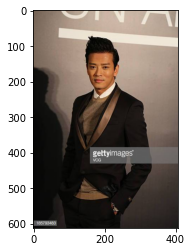

Caption: actor attends the opening ceremony of exhibition


In [124]:
index=34 
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

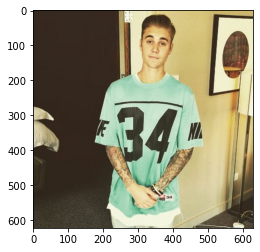

Caption: artist on the cover


In [99]:
index=185  
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

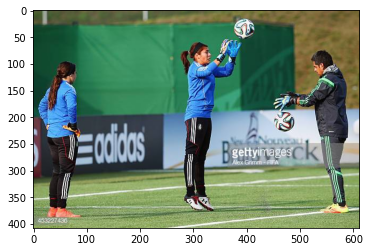

Caption: athlete of on the playing during his match against sports team


In [109]:
index=48 
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

In [132]:
caption_model.optimizer.learning_rate = 1e-4
number_pics_per_batch = 10
steps = len(data['caption']) // number_pics_per_batch

for i in tqdm(range(EPOCHS)):
    generator = data_generator(data, encoded_images, wordtoidx, max_length, number_pics_per_batch)
    caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - loss: 1.5465


 10%|████▍                                       | 1/10 [00:13<02:02, 13.63s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 1.5129


 20%|████████▊                                   | 2/10 [00:26<01:47, 13.45s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 1.4972


 30%|█████████████▏                              | 3/10 [00:40<01:35, 13.63s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 1.4805


 40%|█████████████████▌                          | 4/10 [00:54<01:21, 13.56s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 1.4836


 50%|██████████████████████                      | 5/10 [01:07<01:06, 13.37s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 1.4543


 60%|██████████████████████████▍                 | 6/10 [01:20<00:53, 13.37s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 1.4424


 70%|██████████████████████████████▊             | 7/10 [01:30<00:36, 12.24s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 1.4165


 80%|███████████████████████████████████▏        | 8/10 [01:42<00:24, 12.24s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 1.3982


 90%|███████████████████████████████████████▌    | 9/10 [01:55<00:12, 12.42s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 1.3866


100%|███████████████████████████████████████████| 10/10 [02:07<00:00, 12.78s/it]


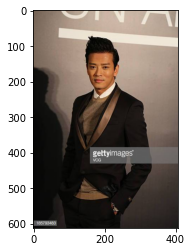

Caption: actor attends the opening ceremony of exhibition


In [134]:
index=34 
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

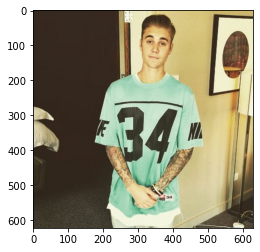

Caption: artist on the cover


In [135]:
index=185  
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

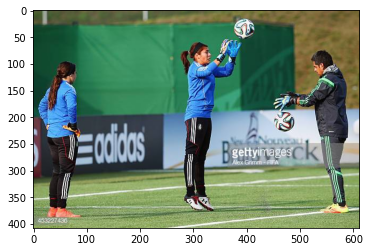

Caption: athlete of during the match


In [137]:
index=48 
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

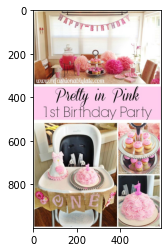

Caption: birthday cake for a heart


In [141]:
index= 194

image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))

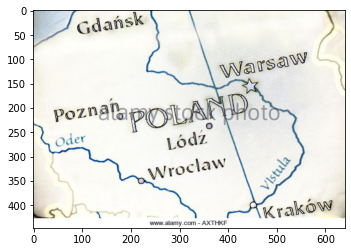

Caption: a map showing the different and several


In [142]:
index=1500
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/home/db21160/Desktop/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))